In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [3]:
u_control_dset = xr.open_dataset("/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/uas/gn/files/d20190410/uas_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc")
#Met Office UK ESM model, control run zonal wind (u) at surface for 2050-2149 inclusive
v_control_dset = xr.open_dataset("/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/vas/gn/files/d20190410/vas_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc")
#Met Office UK ESM model, control run meridional wind (v) at surface for 2050-2149 inclusive

In [4]:
u_control_months_20802100 = u_control_dset['uas'].where(u_control_dset['time.year'] > 2080, drop=True).where(u_control_dset['time.year'] <=2100, drop=True).groupby('time.month').mean(dim='time')\
.interp(lon=np.arange(360), kwargs={"fill_value": "extrapolate"}).interp(lat=np.arange(89,-90,-1))
#Narrowed down to 2081-2100 inclusive, time averaged for each month of year, interpolated on to 1x1 grid

v_control_months_20802100 = v_control_dset['vas'].where(v_control_dset['time.year'] > 2080, drop=True).where(v_control_dset['time.year'] <=2100, drop=True).groupby('time.month').mean(dim='time')\
.interp(lon=np.arange(360), kwargs={"fill_value": "extrapolate"}).interp(lat=np.arange(89,-90,-1))
#As with u

u_normalised = u_control_months_20802100/np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2)
v_normalised = v_control_months_20802100/np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2)
#Normalised against overall wind speed magnitude, for arrows in plots.

In [6]:
# Get migration timings
terns = pd.read_csv("Documents/arctic_tern_migration.csv")
# Using dayfirst instead of format as times are in different formats
terns["Date_Time"] = pd.to_datetime(terns["Date"] + " " + terns["Time"], dayfirst = True)
terns = terns.dropna(subset = ["Lat", "Long"])
# get the month
terns["Month"] = pd.DatetimeIndex(terns["Date_Time"]).month
terns = terns.reindex(range(0, len(terns)))

# Removing erroneous results
x = []

for i in range(1, len(terns)):
    diff_lat = abs(terns.iloc[i]["Lat"] - terns.iloc[i-1]["Lat"])
    diff_long = abs(terns.iloc[i]["Long"] - terns.iloc[i-1]["Long"])
    if ((terns.iloc[i]["Bird ID"] == terns.iloc[i-1]["Bird ID"]) & 
        ((diff_lat > 20) | (diff_long > 20))):
        x.append(i)

for i in range(1, len(x)):
    if (x[i] - x[i-1] == 1):
        terns = terns.drop(index = x[i-1])
        
terns = terns.reindex(range(0, len(terns)))

In [9]:
# Drop bird with weird observations
terns_plt = terns.drop(terns[terns["Bird ID"] == "E (Y2)"].index)
# Use only Egevang for now
terns_plt = terns_plt[terns_plt["Study"] == "Egevang"]

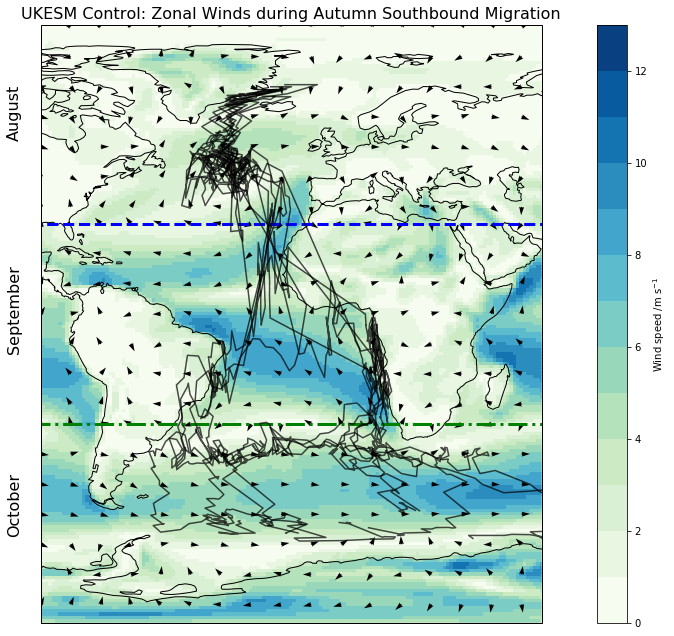

In [28]:
terns_autumn = terns_plt[(terns_plt["Month"] > 7) & (terns_plt["Month"] < 12)]

#Winds during southbound migration
fig = plt.figure(figsize=[20,11])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0)) #PlateCarree(longitude_of_centreline)
ax.coastlines()

np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2).where(u_control_months_20802100['lat'] >= 30, drop=True)[7].plot(ax=ax, cmap=plt.get_cmap("GnBu", 13),vmin=0,vmax=13, cbar_kwargs={"label":"Wind speed /m s$^{-1}$"}) #September
#Line above: wind magnitude above 30 degrees for month 7 = August (as months indexed from 0 to 11)
ax.quiver(np.arange(360)[::9], np.arange(89,30,-1)[::9], u_normalised.where(u_normalised['lat'] >= 30, drop=True)[7][::9,::9], v_normalised.where(v_normalised['lat'] >= 30, drop=True)[7][::9,::9], scale=60)
#Line above: wind directions as arrows of equal length

np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2).where(np.abs(u_control_months_20802100['lat']) < 30, drop=True)[8].plot(ax=ax, cmap=plt.get_cmap("GnBu", 13),vmin=0,vmax=13, add_colorbar=False) #October
ax.quiver(np.arange(360)[::9], np.arange(30,-31,-1)[::9], u_normalised.where(np.abs(u_normalised['lat']) <=30, drop=True)[8][::9,::9], v_normalised.where(np.abs(v_normalised['lat']) <= 30, drop=True)[8][::9,::9], scale=60)
#As before, but for month 8 = September and between +/- 30 degrees

np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2).where(u_control_months_20802100['lat'] <= -30, drop=True)[9].plot(ax=ax, cmap=plt.get_cmap("GnBu", 13),vmin=0,vmax=13, add_colorbar=False) #November
ax.quiver(np.arange(360)[::9], np.arange(-30,-90,-1)[::9], u_normalised.where(u_normalised['lat'] <= -30, drop=True)[9][::9,::9], v_normalised.where(v_normalised['lat'] <= -30, drop=True)[9][::9,::9], scale=60)
#As before, but for month 9 = October and below -30 degrees

ax.plot([-180,180],[30,30], "b--", linewidth=3)
ax.plot([-180,180],[-30,-30], "g-.", linewidth=3)
#Shows where the map is split in to months

ax.text(-100, 68, "August", rotation=90, fontsize=16)
ax.text(-100, 14, "September", rotation=90, fontsize=16)
ax.text(-100, -48, "October", rotation=90, fontsize=16)
#Month labels, first two numbers are position in degrees long, lat

fig.patch.set_facecolor('white')
#Avoids transparent backgrounds, although I'm not sure it has worked

ax.set_xlim(-90,60) #Only shows area around Atlantic. If changed, scale variable on quiver plots may need changing too.
ax.set_title("UKESM Control: Zonal Winds during Autumn Southbound Migration", fontsize = 16) #Removes automatically set title.


for bird in terns_autumn["Bird ID"].unique():
    df = terns_autumn[terns_autumn["Bird ID"] == bird]
    ax.plot(df["Long"], df["Lat"], color = "k", alpha = 0.7)

fig.savefig("./ukesm_control_southbound_egevang.png", dpi=150, bbox_inches="tight") #Saves figure; bbox_inches part removes empty space

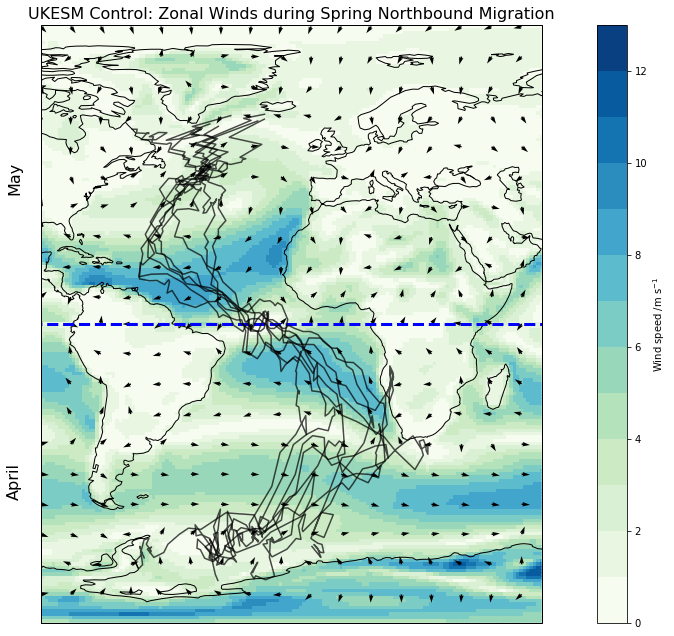

In [29]:
terns_spring = terns_plt[(terns_plt["Month"] > 3) & (terns_plt["Month"] < 6)]

#Northward migration, split in to two months. See previous block for explanation of code

fig = plt.figure(figsize=[20, 11])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
ax.coastlines()

np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2).where(u_control_months_20802100['lat'] >= 0, drop=True)[4].plot(ax=ax, cmap=plt.get_cmap("GnBu", 13),vmin=0,vmax=13, cbar_kwargs={"label":"Wind speed /m s$^{-1}$"}) #May
ax.quiver(np.arange(360)[::9], np.arange(89,0,-1)[::9], u_normalised.where(u_normalised['lat'] >= 0, drop=True)[4][::9,::9], v_normalised.where(v_normalised['lat'] >= 0, drop=True)[4][::9,::9], scale=60)

np.sqrt(u_control_months_20802100**2 + v_control_months_20802100**2).where(u_control_months_20802100['lat'] <= 0, drop=True)[3].plot(ax=ax, cmap=plt.get_cmap("GnBu", 13),vmin=0,vmax=13, add_colorbar=False) #April
ax.quiver(np.arange(360)[::9], np.arange(-0,-90,-1)[::9], u_normalised.where(u_normalised['lat'] <= 0, drop=True)[3][::9,::9], v_normalised.where(v_normalised['lat'] <= 0, drop=True)[3][::9,::9], scale=60)

ax.plot([-180,180],[0,0], "b--", linewidth=3)

ax.text(-100,45, "May", rotation=90, fontsize=16)
ax.text(-100,-45, "April", rotation=90, fontsize=16)

ax.set_xlim(-90,60)
ax.set_title("UKESM Control: Zonal Winds during Spring Northbound Migration", fontsize = 16)


for bird in terns_spring["Bird ID"].unique():
    df = terns_spring[terns_spring["Bird ID"] == bird]
    ax.plot(df["Long"], df["Lat"], color = "k", alpha = 0.7)


fig.savefig("./ukesm_control_northbound_egevang.png", dpi=150, bbox_inches="tight") #Saves figure; bbox_inches part removes empty space